# Projet Optimisation

---
## Question 1.B
Dans cette section, nous implémentons et résolvons le première modèle de la question 1) à savoir :
$$
\begin{align*}
    \max_{c_i, \gamma} \quad  
    &\gamma \\ 
    \sum_{i=0}^{n-1} c_i &= P\\
    \sum_{\text{\tiny offshore}}c_i &= \kappa P\\
    \gamma &\le \sum_{i=0}^{n-1} c_i e_i(t_j) \quad \forall j \in \{0, \ldots, m-1\}\\
    0 &\le \, c_i \, \le c_i^{\max} \quad \forall i \in \{0, \ldots, n-1\}
\end{align*}
$$

---

In [1]:
# Imports
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize) # To print more elements of an array in terminal
import pandas as pd
from scipy.optimize import linprog
import matplotlib.pyplot as plt

### Paramètres globaux

In [2]:
P = 500_000
k = 0.17
T = 3
delta = 0.02

### Lecture des données

In [3]:
# Loads dataframe
sites_df = pd.read_csv('Data-partie-1/Sites.csv')
offshore_df = pd.read_csv('Data-partie-1/Rendements_offshore.csv', header=None).to_numpy()
onshore_df = pd.read_csv('Data-partie-1/Rendements_onshore.csv', header=None).to_numpy()

# Get index of onshore and offshore sites and convert to numpy array
offshore_idx = sites_df[sites_df['capacite offshore'] == 'Oui']['index site'].to_numpy(dtype=int)
onshore_idx = sites_df[sites_df['capacite offshore'] == 'Non']['index site'].to_numpy(dtype=int)

# Get number of sites (n) and number of hours in a year (m)
n = sites_df.shape[0]
m = offshore_df.shape[1]

# Get max capacity of offshore and onshore sites
max_capacity = np.zeros(n)
max_capacity[offshore_idx] = sites_df[sites_df['capacite offshore'] == 'Oui']['capacites'].to_numpy(dtype=float)
max_capacity[onshore_idx] = sites_df[sites_df['capacite offshore'] == 'Non']['capacites'].to_numpy(dtype=float)

# Filter offshore and onshore dataframes
offshore_df = offshore_df[offshore_idx, :]
onshore_df = onshore_df[onshore_idx, :]
rendements_on_off = np.zeros((n, m)) # Matrix that contains all the rendements of onshore and offshore sites at the correct indices
rendements_on_off[offshore_idx, :] = offshore_df
rendements_on_off[onshore_idx, :] = onshore_df

### Modélisation

In [4]:
# Create A_eq matrix
A_eq = np.zeros((2, n+1))
A_eq[0, :-1] = np.ones(n) # Sum of all c_i = P
A_eq[1, offshore_idx] = 1 # Sum of all c_i for offshore sites = k*P

# Create b_eq matrix
b_eq = np.zeros(2)
b_eq[0] = P
b_eq[1] = k*P

# Create A_ub matrix
A_ub = np.ones((m, n+1))
A_ub[:, :-1] = -rendements_on_off.T # Gamma constraint

# Create b_ub matrix
b_ub = np.zeros(m)

# Create bounds for c_i
bounds = [(0, None) for i in range(n+1)]
# bounds[-1] = (None, None)
for i in offshore_idx:
    bounds[i] = (0, max_capacity[i])
for i in onshore_idx:
    bounds[i] = (0, max_capacity[i])

# Create variable array
objective_function = np.zeros(n+1)
objective_function[-1] = -1

### Résolution du modèle

In [5]:
# Solve linear program
sol = linprog(c=objective_function, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds)
np.save('Data-partie-1/solution_Q1.npy', sol.x)
print(sol.x[sol.x != 0].shape)

(268,)


### Mesure de performances

In [ ]:
import time
n = 100
execution_time = np.zeros(n)
for i in range(n):
    start = time.time()
    sol = linprog(c=objective_function, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds)
    end = time.time()
    execution_time[i] = end - start

plt.plot(np.arange(n), execution_time)
plt.axhline(np.mean(execution_time), color='r', linestyle='--', label='Average execution time')
plt.xlabel('Iteration')
plt.ylabel('Execution time (s)')
plt.title('Execution time')
plt.legend()
plt.savefig('Graphes/Graphes_Q1/execution_time.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

print(f'Average execution time: {np.mean(execution_time)}')


## Visualisation du résultat obtenu
---

### Calcul de l'énergie produite

Total energy produced: 1828762.5653978167 [GWh]


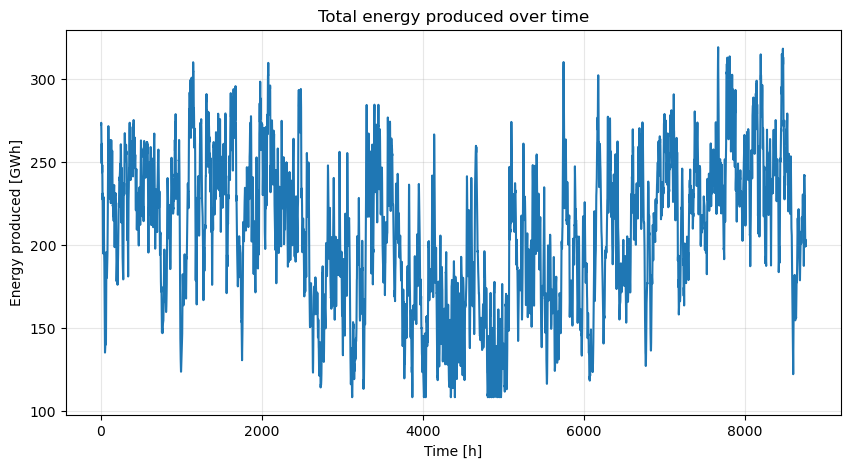

In [6]:
# Load solution
sol = np.load('Data-partie-1/solution_Q1.npy')

# Compute energy produced per hour
energy_produced = np.zeros(m)
for i in range(m):
    energy_produced[i] += sol[offshore_idx]@offshore_df[:, i]
    energy_produced[i] += sol[onshore_idx]@onshore_df[:, i]

# Plot energy produced over time
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Total energy produced over time')
plt.plot(t, energy_produced/1e3)
plt.xlabel('Time [h]')
plt.ylabel('Energy produced [GWh]')
plt.grid(alpha=0.3)
plt.savefig('Graphes/Graphes_Q1/energy_produced.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

# Compute total energy produced
total_energy_produced = np.sum(energy_produced)
print('Total energy produced:', total_energy_produced/1e3, '[GWh]')

### Calcul du rendement

Average efficiency : 41.752569986251515 [%]


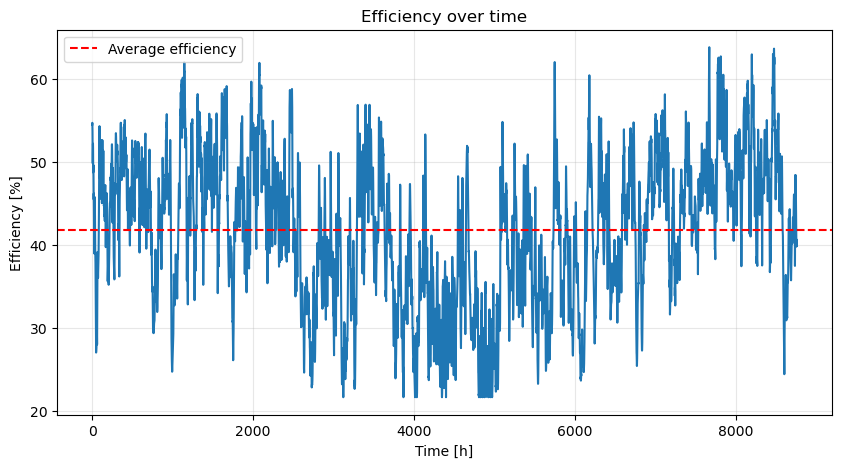

In [7]:
# Load solution
sol = np.load('Data-partie-1/solution_Q1.npy')

# Compute energy produced per hour
energy_produced = np.zeros(m)
for i in range(m):
    energy_produced[i] += sol[offshore_idx]@offshore_df[:, i]
    energy_produced[i] += sol[onshore_idx]@onshore_df[:, i]

# Plots efficiency over time (ratio between energy produced and maximum energy producible)
efficiency = energy_produced / P * 100
average_efficiency = np.mean(efficiency)
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Efficiency over time')
plt.plot(t, efficiency)
plt.axhline(y=average_efficiency, color='r', linestyle='--', label='Average efficiency')
plt.xlabel('Time [h]')
plt.ylabel('Efficiency [%]')
plt.grid(alpha=0.3)
plt.legend()
plt.savefig('Graphes/Graphes_Q1/efficiency.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

print('Average efficiency :', average_efficiency, '[%]')

### Répartition de la puissance installée sur les différents sites

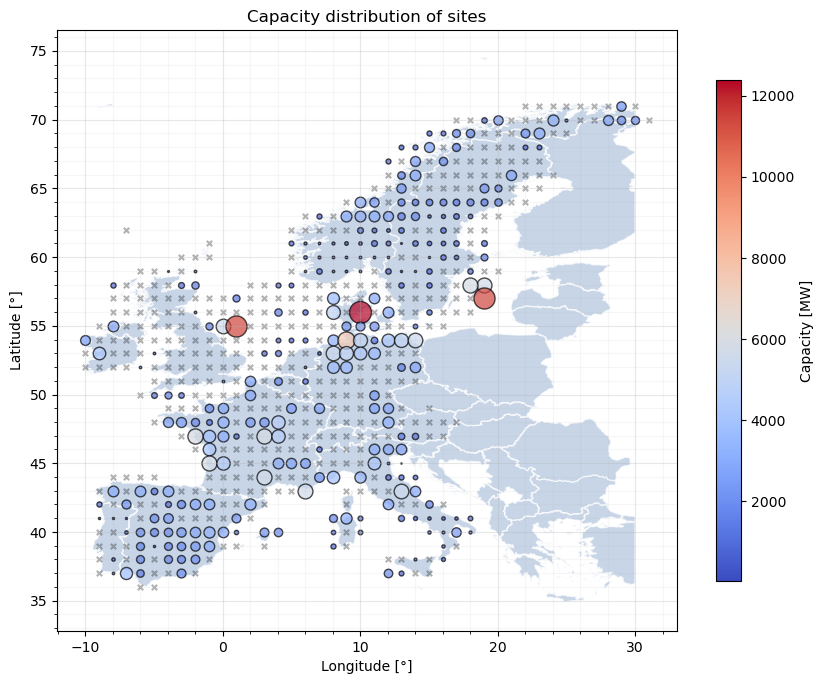

In [8]:
import geopandas as gpd
from shapely.geometry import Polygon

data_dir = 'ref-nuts-2021-01m/'
path_rg = data_dir + "NUTS_RG_01M_2021_4326_LEVL_0.json"
gdf_rg = gpd.read_file(path_rg)
path_bn = data_dir + "NUTS_BN_01M_2021_4326_LEVL_0.json"
gdf_bn = gpd.read_file(path_bn)
path_lb = data_dir + "NUTS_LB_2021_4326_LEVL_0.json"
gdf_lb = gpd.read_file(path_lb)


def make_bbox(long0, lat0, long1, lat1):
    return Polygon([[long0, lat0],
                    [long1,lat0],
                    [long1,lat1],
                    [long0, lat1]])

bbox = make_bbox(-10,30,30,75)
bbox_gdf = gpd.GeoDataFrame(index=[0], geometry = [bbox], crs=gdf_rg.crs)

gdf_rg = gdf_rg.overlay(bbox_gdf, how="intersection")

gdf_rg.plot(color='lightsteelblue', alpha=0.7, edgecolor='white', figsize=(10,10))

# Plot capacities as circles

max_capacity = np.max(sol[:-1])
min_capacity = np.min(sol[sol > 0][:-1])

cm = plt.get_cmap('coolwarm')
cNorm = plt.Normalize(vmin=min_capacity, vmax=max_capacity)
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=cm)

for i in range(n):
    if sol[i] > 0:
        site = sites_df.iloc[i]
        capacity = sol[i]
        marker_size = 250*capacity/max_capacity
        plt.scatter(site['longitude'], site['latitude'], c=capacity, vmin=min_capacity, vmax=max_capacity, cmap=cm, s=marker_size, alpha=0.7, edgecolors='black')
    else:
        site = sites_df.iloc[i]
        plt.scatter(site['longitude'], site['latitude'], c='black', marker='x', s=15, alpha=0.3)


ax, fig = plt.gca(), plt.gcf()
plt.title("Capacity distribution of sites")
plt.colorbar(scalarMap, label='Capacity [MW]', shrink=0.65, ax=ax)
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(alpha=0.3, which='major')
plt.grid(alpha=0.1, which='minor')
plt.minorticks_on()
plt.savefig('Graphes/Graphes_Q1/capacity_distribution.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

---
## Question 2.A
Dans cette seconde question, il est maintenant possible d'acheter de l'énergie en plus de celle produite par les éoliennes. Cependant, nous pouvons acheter qu'une quantité limitée $E_{max}$. En introduisant, $m$ nouvelles variables $a_j$ correspondant à la quantité d'énergie achetée en chaque heure de l'année, le modèle devient le suivant :

$$
\begin{align*}
    \max_{c_i, a_j, \gamma} \quad  &\gamma \\ 
    \sum_{i=0}^{n-1} c_i &= P\\
    \sum_{\text{\tiny offshore}}c_i &= \kappa P\\
    \gamma &\le \sum_{i=0}^{n-1} c_i e_i(t_j) + a_j \quad \forall j \in \{0, \ldots, m-1\}\\
    \sum _{j=0}^{m-1} a_j &\le E_{\text{max}}\\
    0 &\le \, c_i \, \le c_i^{\max} \quad \forall i \in \{0, \ldots, n-1\}\\
    a_j &\ge 0 \quad \forall j \in \{0, \ldots, m-1\}
\end{align*}
$$

Pour cette section, le vecteur des variables de décisions est le vecteur contenant d'abord tous les $c_i$, ensuite tous les $a_j$ et enfin la variable $\gamma$ :
$$x = (c_0, \ldots, c_{n-1}, a_0, \ldots, a_{m-1}, \gamma)$$

---

### Paramètres 2.A

In [10]:
E_max_step = 1e8
E_min, E_max = 0, 1e9
E_max_range = np.arange(E_min, E_max, E_max_step)

### Modélisation

In [11]:
# Create A_eq matrix
A_eq = np.zeros((2, n+m+1))
A_eq[0, :n] = np.ones(n) # Sum of all c_i = P
A_eq[1, offshore_idx] = 1 # Sum of all c_i for offshore sites = k*P

# Create b_eq vector
b_eq = np.zeros(2)
b_eq[0] = P
b_eq[1] = k*P

# Create A_ub matrix
A_ub = np.zeros((m+1, n+m+1)) # m constraints for gamma and 1 constraint for the sum of a_j
A_ub[:m, :n] = -rendements_on_off.T # c_i
A_ub[:m, n:n+m] = -np.eye(m) # a_j
A_ub[:m, -1] = 1 # gamma
A_ub[-1, n:n+m] = 1 # sum of a_j

# Create b_ub vector
b_ub = np.zeros(m+1)
b_ub[:m] = 0
b_ub[-1] = None # Change that by corresponding E_max value within the range E_max_range

# c_i and a_j bounds
bounds = [(0, None) for i in range(n+m+1)]
for i in offshore_idx:
    bounds[i] = (0, max_capacity[i])
for i in onshore_idx:
    bounds[i] = (0, max_capacity[i])

for i in range(n, n+m):
    bounds[i] = (0, None)

objective_function = np.zeros(n+m+1)
objective_function[-1] = -1

### Résolution du modèle

In [12]:
solutions_matrix = np.zeros((E_max_range.shape[0], n+m+1))

# Solve linear program
for i, E in enumerate(E_max_range):
    b_ub[-1] = E
    sol = linprog(c=objective_function, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds)
    solutions_matrix[i] = sol.x

# Save solutions and E_max_range
np.save("Data-partie-1/solution_Q2", solutions_matrix)
np.save("Data-partie-1/E_max_range_Q2", E_max_range)

### Représentation graphique des solutions

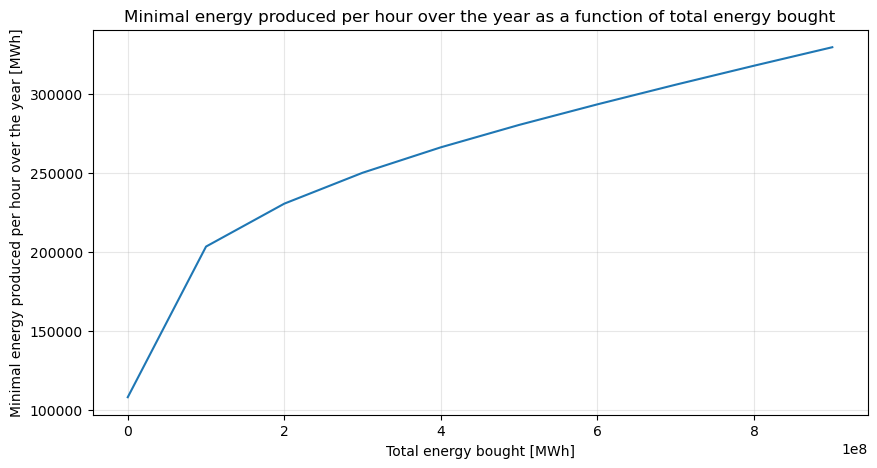

In [9]:
solutions = np.load("Data-partie-1/solution_Q2.npy")
E_max_range = np.load("Data-partie-1/E_max_range_Q2.npy")

fig = plt.figure(figsize=(10, 5))
plt.plot(E_max_range, solutions[:, -1])
plt.xlabel('Total energy bought [MWh]')
plt.ylabel('Minimal energy produced per hour over the year [MWh]')
plt.title('Minimal energy produced per hour over the year as a function of total energy bought')
plt.grid(alpha=0.3)
plt.savefig('Graphes/Graphes_Q2/minimal_energy_produced.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

### Graphes de l'énergie produite et achetée en fonction du temps

In [ ]:
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

# The higher the better, so we take the last value
sol = np.load('Data-partie-1/solution_Q2.npy')[-1]
E_max = np.load('Data-partie-1/E_max_range_Q2.npy')[-1]

# Compute energy produced per hour
energy_produced = np.zeros(m)
for i in range(m):
    energy_produced[i] += sol[offshore_idx]@offshore_df[:, i]
    energy_produced[i] += sol[onshore_idx]@onshore_df[:, i]

# Creates three subplots : 
# 1. Energy produced over time
# 2. Energy bought at each time
# 3. Total energy produced and bought over time

t = np.arange(1, m+1)
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2)

# Energy produced over time
ax = fig.add_subplot(gs[0, 0])
ax.plot(t, energy_produced/1e3)
ax.set_title('Wind turbine energy production over time')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Energy produced [GWh]')
ax.set_ylim(0, 1.1*np.max(energy_produced/1e3))
ax.grid(alpha=0.3)

# Energy bought at each time
energy_bought = sol[n:n+m]
ax = fig.add_subplot(gs[0, 1])
ax.plot(t, energy_bought/1e3)
ax.set_title('Energy bought over time')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Energy bought [GWh]')
ax.set_ylim(0, 1.1*np.max(energy_produced/1e3))
ax.grid(alpha=0.3)

# Total energy produced and bought over time
ax = fig.add_subplot(gs[1, :])
ax.plot(t, (energy_produced + energy_bought)/1e3, label='Total energy produced')
ax.set_title('Total energy produced and bought over time')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Energy [GWh]')
ax.set_ylim(0, 1.1*np.max(energy_produced/1e3))
ax.grid(alpha=0.3)

plt.savefig('Graphes/Graphes_Q2/energy_produced_and_bought.pdf', format='pdf', bbox_inches='tight', pad_inches=0)